# 文本数据准备

- 1. 将文本作为字符串加载到内存中。

- 2. 将字符串拆分为词元（如单词和字符）。

- 3. 建立一个词表，将拆分的词元映射到数字索引。

- 4. 将文本转换为数字索引序列，方便模型操作

In [8]:
import collections
import re
from d2l import torch as d2l
import os
import math
import random
import torch

首先，我们从H.G.Well的时光机器中加载文本。将数据集读取到由多条文本行组成的列表中，其中每条文本行都是一个字符串。 为简单起见，我们在这里忽略了标点符号和字母大写。

In [2]:
#@save
d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt',
                                '090b5e7e70c295757f55df93cb0a180b9691891a')

def read_time_machine():  #@save
    """将时间机器数据集加载到文本行的列表中"""
    with open(d2l.download('time_machine'), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]
#sub('[^A-Za-z]+', ' ', line): 使用正则表达式替换每行中的非英文字母字符为单个空格。
#strip: 删除每行首尾的空白字符。
lines = read_time_machine()
print(f'# 文本总行数: {len(lines)}')
print(lines[0])
print(lines[10])

# 文本总行数: 3221
the time machine by h g wells
twinkled and his usually pale face was flushed and animated the


## 词元, 词表

* tokenize函数:
* input: 文本行列表（lines）
* 列表中的每个元素是一个文本序列（如一条文本行）
* 每个文本序列又被拆分成一个词元列表
* 词元（token）是文本的基本单位
* output: 一个由词元列表组成的列表，其中的每个词元都是一个字符串（string）

In [4]:
lines[0:10]

['the time machine by h g wells',
 '',
 '',
 '',
 '',
 'i',
 '',
 '',
 'the time traveller for so it will be convenient to speak of him',
 'was expounding a recondite matter to us his grey eyes shone and']

In [3]:
def tokenize(lines, token='word'):  #@save
    """将文本行拆分为单词或字符词元"""
    if token == 'word':
        return [line.split() for line in lines]#split()默认以空格为分隔符
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('错误：未知词元类型：' + token)

tokens = tokenize(lines)
for i in range(11):
    print(tokens[i])

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']


* 语料（corpus）$\\$
训练集中的所有文档合并在一起，对它们的唯一词元进行统计， 得到的统计结果, 然后根据每个唯一词元的出现频率，为其分配一个数字索引。 $\\$
* 词表（vocabulary）$\\$
词元的类型是字符串，而模型需要的输入是数字，因此这种类型不方便模型使用。 现在，让我们构建一个字典(**独热编码**)， 用来将字符串类型的词元映射到从0开始的数字索引中。
`很少出现的词元通常被移除，这可以降低复杂性。 另外，语料库中不存在或已删除的任何词元都将映射到一个特定的未知词元“<unk>”。 我们可以选择增加一个列表，用于保存那些被保留的词元， 例如：填充词元（“<pad>”）； 序列开始词元（“<bos>”）； 序列结束词元（“<eos>”）。` 

In [5]:
class Vocab:  #@save
    """文本词表"""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        #接受三个参数：tokens（一个包含词元的列表），
        # min_freq（一个词元在tokens中出现的最小频率，
        # 低于这个频率的词元将不会被加入到词汇表中），
        # reserved_tokens（一个预留词元的列表，这些词元将始终被加入到词汇表中）。
        # 在函数中，首先根据tokens生成一个词频表，并按词频降序排序。
        # 然后创建两个字典，一个是从词元到索引的映射（token_to_idx），
        # 一个是从索引到词元的映射（idx_to_token）
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # 按出现频率排序
        counter = count_corpus(tokens)
        #counter.items()将词频表counter转换为一个包含键-值对的元组列表。
        # 每个键-值对表示一个词元及其对应的频率。
        # key=lambda x: x[1]指定排序的关键字，
        # 即按照每个键-值对的第二个元素（频率）进行排序。
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # 未知词元的索引为0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        #通过isinstance(tokens, (list, tuple))判断传入的参数是否是一个列表或元组。
        # 如果不是列表或元组，则表示只传入了单个词元。
        if not isinstance(tokens, (list, tuple)):
            #如果传入的是单个词元，那么通过self.token_to_idx.get(tokens, self.unk)
            # 尝试从词元到索引的映射字典self.token_to_idx中获取该词元对应的索引。
            # 如果找不到该词元，则返回未知词元索引self.unk
            return self.token_to_idx.get(tokens, self.unk)
        #如果传入的是一个词元列表或元组，
        # 那么通过列表推导式[self.__getitem__(token) for token in tokens]
        # 逐个递归调用__getitem__方法，获取每个词元对应的索引，
        # 并将结果存入一个新的列表中
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    #这段代码是类Vocab中的两个装饰器@property，分别是unk和token_freqs。

#@property装饰器将unk方法转变为一个只读属性。
# 这意味着可以通过访问vocab.unk来获取未知词元的索引0，
# 但不能对其进行赋值。

#这样，通过unk属性可以方便地获取未知词元的索引，
# 通过token_freqs属性可以方便地获取词元的频率表。
    @property
    def unk(self):  # 未知词元的索引为0
        return 0
    
#@property装饰器将token_freqs方法转变为一个只读属性。
# 这意味着可以通过访问vocab.token_freqs来获取词元的频率表，
# 但不能对其进行赋值。
    @property
    def token_freqs(self):
        return self._token_freqs
    

def count_corpus(tokens):  #@save
    """统计词元的频率"""
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元列表展平成一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

In [6]:
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])

[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]


In [7]:
#将每一条文本行转换成一个数字索引列表
for i in [0, 10]:
    print('文本:', tokens[i])
    print('索引:', vocab[tokens[i]])

文本: ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
索引: [1, 19, 50, 40, 2183, 2184, 400]
文本: ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
索引: [2186, 3, 25, 1044, 362, 113, 7, 1421, 3, 1045, 1]


整合
- 将所有功能打包到`load_corpus_time_machine`函数中， 该函数返回`corpus`（词元索引列表）和`vocab`（时光机器语料库的词表）。 在这里所做的改变是：

* 为了简化后面章节中的训练，我们使用字符（而不是单词）实现文本词元化；

* 时光机器数据集中的每个文本行不一定是一个句子或一个段落，还可能是一个单词，因此返回的`corpus`仅处理为单个列表，而不是使用多词元列表构成的一个列表。

In [8]:
def load_corpus_time_machine(max_tokens=-1):  #@save
    """返回时光机器数据集的词元索引列表和词表"""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # 因为时光机器数据集中的每个文本行不一定是一个句子或一个段落，
    # 所以将所有文本行展平到一个列表中
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)

(170580, 28)

**独热编码**不能编码词向量之间的相似性

# Embedding, word->vector

**词向量**是用于表示单词意义的向量， 并且还可以被认为是单词的特征向量或表示。 将单词映射到实向量的技术称为**词嵌入**

**word2vec**
* 2013年google团队提出的词嵌入模型
* 每个词映射到一个固定长度的向量，这些向量能更好地表达不同词之间的相似性和类比关系。word2vec工具包含两个模型，即**跳元模型**（skip-gram） (Mikolov et al., 2013)和**连续词袋**（CBOW） (Mikolov et al., 2013)。`对于在语义上有意义的表示，它们的训练依赖于条件概率，条件概率可以被看作使用语料库中一些词来预测另一些单词。由于是不带标签的数据，因此跳元模型和连续词袋都是自监督模型`

## 跳元模型（Skip-Gram）

**跳元模型假设一个词可以用来在文本序列中生成其周围的单词**。
![](../Week5%20NLP/img/skipgram.png)
以文本序列“the”“man”“loves”“his”“son”为例。假设中心词选择“loves”，并将上下文窗口设置为2，如图 图14.1.1所示，给定中心词“loves”，跳元模型考虑生成上下文词“the”“man”“him”“son”的条件概率：$$P("the","man","his","son"|"loves")$$
![](../image/14.1.1.png)
对于词典中索引为i的任何词，分别用$ v_i \in \mathbb{R}^d $和$u_i \in \mathbb{R}^d $表示其用作中心词和上下文词时的两个向量。给定中心词$w_c$（词典中的索引c），生成任何上下文词$w_o$（词典中的索引o）的条件概率可以通过对向量点积的softmax操作来建模：$$P(w_o |w_c )=\frac{exp(u_{o}^T v_c )}{\sum_{i\in \mathbb{V} exp(u_{i}^T v_c )}}$$
其中词表索引集$\mathbb{V}=\{0,1,...,|\mathbb{V}|-1\}$。给定长度为T的文本序列，其中时间步t处的词表示为$w^{(t)}$。假设上下文词是在给定任何中心词的情况下独立生成的。对于上下文窗口m，跳元模型的似然函数是在给定任何中心词的情况下生成所有上下文词的概率：$$\prod_{t=1}^T \prod_{-m\le j \le m,j\ne 0}P(w^{(t+j)}|w^{(t)})$$ 

跳元模型参数是词表中每个词的中心词向量和上下文词向量。在训练中，我们通过最大化似然函数（即极大似然估计）来学习模型参数。这相当于最小化以下损失函数:$$-\sum_{t=1}^T \sum_{-m\le j \le m,j\ne 0}logP(w^{(t+j)}|w^{(t)})$$ 
当使用随机梯度下降来最小化损失时，在每次迭代中可以随机抽样一个较短的子序列来计算该子序列的（随机）梯度，以更新模型参数。为了计算该（随机）梯度，我们需要获得对数条件概率关于中心词向量和上下文词向量的梯度。通常，根据 (14.1.4)，涉及中心词$w_c $和上下文词$w_o $的对数条件概率为:
$$ logP(w_0 |w_c )=u_{0}^T v_c -log(\sum_{i \in \mathbb{V}}exp(u_{i}^T v_c ))$$
微分, 得到相对于中心词向量v_c梯度:
$$
\begin{align*} 
\frac{\partial \log P(w_0 | w_c )}{\partial v_c} &= u_0 - \frac{\sum_{i \in \mathbb{V}} \exp(u_i^T v_c) u_j}{\sum_{i \in \mathbb{V}} \exp(u_i^T v_c)} \\
 &= u_0 -\sum_{j \in \mathbb{V}}P(w_j | w_c )u_j \\
\end{align*}
$$


## BOW bag of word 词袋模型

**BOW假设上下文生成一个中心词**
![](../Week5%20NLP/img/CBOW.png)

由于连续词袋模型中存在多个上下文词，因此在计算条件概率时对这些上下文词向量进行平均。具体地说，对于字典中索引
的任意词，分别用$v_i \in \mathbb{R}^d$和$u_i \in \mathbb{R}^d$表示用作上下文词和中心词的两个向量（符号与跳元模型中相反）。给定上下文词$w_{o1},...,w_{o2m}$（在词表中索引是$(o_1 ,...,o_{2m})$）生成任意中心词$w_c$（在词表中索引是c）的条件概率可以由以下公式建模:
$$P(w_c |w_{o1},...,w_{o2m})=\frac{exp(\frac{1}{2m}u_{c}^T(v_{o1}+...+v_{o2m}))}{\sum_{i\in \mathbb{V}}exp(\frac{1}{2m}u_{i}^T(v_{o1}+...+v_{o2m}))}$$
给定长度为T的文本序列，其中时间步t处的词表示为$w_{(t)}$。对于上下文窗口m，连续词袋模型的似然函数是在给定其上下文词的情况下生成所有中心词的概率
$$ \prod_{t=1}^T P(w_{(t)}|w_{(t-m)},...,w_{(t-1)},w_{(t+1)},...,w_{(t+m)})$$
连续词袋模型的最大似然估计等价于最小化以下损失函数：
$$-\sum_{t=1}^T logP(w_{(t)}|w_{(t-m)},...,w_{(t-1)},w_{(t+1)},...,w_{(t+m)})$$

# 近似训练
* 跳元模型的主要思想是使用softmax运算来计算基于给定的中心词
生成上下文字$w_0$的条件概率。

* 由于softmax操作的性质，上下文词可以是词表V中的任意项， 上面包含与整个词表大小一样多的项的求和。因此，跳元模型的梯度计算和 连续词袋模型的梯度计算都包含求和。不幸的是，在一个词典上（通常有几十万或数百万个单词）求和的梯度的计算成本是巨大的！

为了降低上述计算复杂度，有两种近似训练方法：负采样和分层softmax。 由于跳元模型和连续词袋模型的相似性，我们将以跳元模型为例来描述这两种近似训练方法。
* 负采样通过考虑相互独立的事件来构造损失函数，这些事件同时涉及正例和负例。训练的计算量与每一步的噪声词数成线性关系。
* 分层softmax使用二叉树中从根节点到叶节点的路径构造损失函数。训练的计算成本取决于词表大小的对数。

# 用于预训练词嵌入的数据集
Penn Tree Bank（PTB）。该语料库取自“华尔街日报”的文章，分为训练集、验证集和测试集。在原始格式中，文本文件的每一行表示由空格分隔的一句话。在这里，我们将每个单词视为一个词元。

In [5]:
#@save
d2l.DATA_HUB['ptb'] = (d2l.DATA_URL + 'ptb.zip',
                       '319d85e578af0cdc590547f26231e4e31cdf1e42')

#@save
def read_ptb():
    """将PTB数据集加载到文本行的列表中"""
    data_dir = d2l.download_extract('ptb')
    # Readthetrainingset.
    with open(os.path.join(data_dir, 'ptb.train.txt')) as f:
        raw_text = f.read()
    return [line.split() for line in raw_text.split('\n')]

sentences = read_ptb()
f'# sentences数: {len(sentences)}'

'# sentences数: 42069'

为语料库构建一个词表，其中出现次数少于10次的任何单词都将由“<unk>”词元替换

In [6]:
vocab = d2l.Vocab(sentences, min_freq=10)
f'vocab size: {len(vocab)}'

'vocab size: 6719'

## 下采样
文本数据通常有“the”“a”和“in”等高频词：它们在非常大的语料库中甚至可能出现数十亿次。然而，这些词经常在上下文窗口中与许多不同的词共同出现，提供的有用信息很少。
此外，大量（高频）单词的训练速度很慢。因此，当训练词嵌入模型时，可以对高频单词进行下采样 (Mikolov et al., 2013)。具体地说，数据集中的每个词$w_i$
将有概率地被丢弃
$$P(w_i )=max(1-\sqrt{\frac{t}{f(w_i )}},0)$$
f(w_i )是w_i的词数与数据集中的总词数的比率,只有当相对比率>t,高频词才能被丢弃，且该词的相对比率越高，被丢弃的概率就越大

In [9]:
#@save
def subsample(sentences, vocab):
    """下采样高频词"""
    # 排除未知词元'<unk>'
    sentences = [[token for token in line if vocab[token] != vocab.unk]
                 for line in sentences]
    counter = d2l.count_corpus(sentences)
    num_tokens = sum(counter.values())

    # 如果在下采样期间保留词元，则返回True
    def keep(token):
        return(random.uniform(0, 1) <
               math.sqrt(1e-4 / counter[token] * num_tokens))

    return ([[token for token in line if keep(token)] for line in sentences],
            counter)

subsampled, counter = subsample(sentences, vocab)

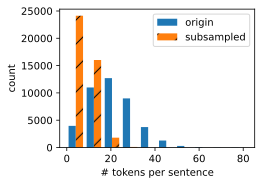

In [10]:
d2l.show_list_len_pair_hist(
    ['origin', 'subsampled'], '# tokens per sentence',
    'count', sentences, subsampled);

对于单个词元，高频词“the”的采样率不到1/20。

相比之下，低频词“join”则被完全保留

In [11]:
def compare_counts(token):
    return (f'"{token}"的数量：'
            f'之前={sum([l.count(token) for l in sentences])}, '
            f'之后={sum([l.count(token) for l in subsampled])}')

compare_counts('the')

'"the"的数量：之前=50770, 之后=2031'

In [12]:
compare_counts('join')

'"join"的数量：之前=45, 之后=45'

将词元映射到它们在语料库中的索引

In [13]:
corpus = [vocab[line] for line in subsampled]
corpus[:3]

[[], [392, 2115, 274, 406], [140, 5277, 3054, 1580]]

## 中心词和上下文词的提取
get_centers_and_contexts函数从corpus中提取所有中心词及其上下文词。它随机采样1到max_window_size之间的整数作为上下文窗口。对于任一中心词，与其距离不超过采样上下文窗口大小的词为其上下文词。

In [14]:
#@save
def get_centers_and_contexts(corpus, max_window_size):
    """返回跳元模型中的中心词和上下文词"""
    centers, contexts = [], []
    for line in corpus:
        # 要形成“中心词-上下文词”对，每个句子至少需要有2个词
        if len(line) < 2:
            continue
        centers += line
        for i in range(len(line)):  # 上下文窗口中间i
            window_size = random.randint(1, max_window_size)
            indices = list(range(max(0, i - window_size),
                                 min(len(line), i + 1 + window_size)))
            # 从上下文词中排除中心词
            indices.remove(i)
            contexts.append([line[idx] for idx in indices])
    return centers, contexts

创建一个人工数据集，分别包含7个和3个单词的两个句子。设置最大上下文窗口大小为2，并打印所有中心词及其上下文词

In [15]:
tiny_dataset = [list(range(7)), list(range(7, 10))]
print('数据集', tiny_dataset)
for center, context in zip(*get_centers_and_contexts(tiny_dataset, 2)):
    print('中心词', center, '的上下文词是', context)

数据集 [[0, 1, 2, 3, 4, 5, 6], [7, 8, 9]]
中心词 0 的上下文词是 [1, 2]
中心词 1 的上下文词是 [0, 2]
中心词 2 的上下文词是 [1, 3]
中心词 3 的上下文词是 [1, 2, 4, 5]
中心词 4 的上下文词是 [3, 5]
中心词 5 的上下文词是 [4, 6]
中心词 6 的上下文词是 [5]
中心词 7 的上下文词是 [8, 9]
中心词 8 的上下文词是 [7, 9]
中心词 9 的上下文词是 [8]


PTB数据集上进行训练时，我们将最大上下文窗口大小设置为5。下面提取数据集中的所有中心词及其上下文词

In [16]:
all_centers, all_contexts = get_centers_and_contexts(corpus, 5)
f'# “中心词-上下文词对”的数量: {sum([len(contexts) for contexts in all_contexts])}'

'# “中心词-上下文词对”的数量: 1503605'

## 负采样
定义以下RandomGenerator类，其中（可能未规范化的）采样分布通过变量sampling_weights传递。


In [17]:
#@save
class RandomGenerator:
    """根据n个采样权重在{1,...,n}中随机抽取"""
    def __init__(self, sampling_weights):
        # Exclude
        self.population = list(range(1, len(sampling_weights) + 1))
        self.sampling_weights = sampling_weights
        self.candidates = []
        self.i = 0

    def draw(self):
        if self.i == len(self.candidates):
            # 缓存k个随机采样结果
            self.candidates = random.choices(
                self.population, self.sampling_weights, k=10000)
            self.i = 0
        self.i += 1
        return self.candidates[self.i - 1]

e.g.在索引123中绘制10个随机变量, 采样概率为2/9,3/9,4/9

In [18]:
#@save
generator = RandomGenerator([2, 3, 4])
[generator.draw() for _ in range(10)]

[2, 3, 3, 3, 3, 2, 1, 3, 2, 1]

对于一对中心词和上下文词，我们随机抽取了K个（实验中为5个）噪声词。根据word2vec论文中的建议，将噪声词w的采样概率P(w)设置为其在字典中的相对频率，其幂为0.75

In [19]:
#@save
def get_negatives(all_contexts, vocab, counter, K):
    """返回负采样中的噪声词"""
    # 索引为1、2、...（索引0是词表中排除的未知标记）
    sampling_weights = [counter[vocab.to_tokens(i)]**0.75
                        for i in range(1, len(vocab))]
    all_negatives, generator = [], RandomGenerator(sampling_weights)
    for contexts in all_contexts:
        negatives = []
        while len(negatives) < len(contexts) * K:
            neg = generator.draw()
            # 噪声词不能是上下文词
            if neg not in contexts:
                negatives.append(neg)
        all_negatives.append(negatives)
    return all_negatives

all_negatives = get_negatives(all_contexts, vocab, counter, 5)

## 小批量加载训练实例
在提取所有中心词及其上下文词和采样噪声词后，将它们转换成小批量的样本，在训练过程中可以迭代加载。

在小批量中，第i个样本包括中心词及其n_i个上下文词和m_i个噪声词。由于上下文窗口大小不同，n_i +m_i 对于不同的i是不同的。因此，对于每个样本，我们在contexts_negatives个变量中将其上下文词和噪声词连结起来，并填充零，直到连结长度达到max(n_i +m_i )(max_len)。为了在计算损失时排除填充，我们定义了掩码变量masks。在masks中的元素和contexts_negatives中的元素之间存在一一对应关系，其中masks中的0（否则为1）对应于contexts_negatives中的填充。

为了区分正反例，我们在contexts_negatives中通过一个labels变量将上下文词与噪声词分开。类似于masks，在labels中的元素和contexts_negatives中的元素之间也存在一一对应关系，其中labels中的1（否则为0）对应于contexts_negatives中的上下文词的正例。

上述思想在下面的batchify函数中实现。其输入data是长度等于批量大小的列表，其中每个元素是由中心词center、其上下文词context和其噪声词negative组成的样本。此函数返回一个可以在训练期间加载用于计算的小批量，例如包括掩码变量。

In [20]:
#@save
def batchify(data):
    """返回带有负采样的跳元模型的小批量样本"""
    max_len = max(len(c) + len(n) for _, c, n in data)
    centers, contexts_negatives, masks, labels = [], [], [], []
    for center, context, negative in data:
        cur_len = len(context) + len(negative)
        centers += [center]
        contexts_negatives += \
            [context + negative + [0] * (max_len - cur_len)]
        masks += [[1] * cur_len + [0] * (max_len - cur_len)]
        labels += [[1] * len(context) + [0] * (max_len - len(context))]
    return (torch.tensor(centers).reshape((-1, 1)), torch.tensor(
        contexts_negatives), torch.tensor(masks), torch.tensor(labels))

In [21]:
x_1 = (1, [2, 2], [3, 3, 3, 3])
x_2 = (1, [2, 2, 2], [3, 3])
batch = batchify((x_1, x_2))

names = ['centers', 'contexts_negatives', 'masks', 'labels']
for name, data in zip(names, batch):
    print(name, '=', data)

centers = tensor([[1],
        [1]])
contexts_negatives = tensor([[2, 2, 3, 3, 3, 3],
        [2, 2, 2, 3, 3, 0]])
masks = tensor([[1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 0]])
labels = tensor([[1, 1, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0]])


整合

In [22]:
#@save
def load_data_ptb(batch_size, max_window_size, num_noise_words):
    """下载PTB数据集，然后将其加载到内存中"""
    num_workers = d2l.get_dataloader_workers()
    sentences = read_ptb()
    vocab = d2l.Vocab(sentences, min_freq=10)
    subsampled, counter = subsample(sentences, vocab)
    corpus = [vocab[line] for line in subsampled]
    all_centers, all_contexts = get_centers_and_contexts(
        corpus, max_window_size)
    all_negatives = get_negatives(
        all_contexts, vocab, counter, num_noise_words)

    class PTBDataset(torch.utils.data.Dataset):
        def __init__(self, centers, contexts, negatives):
            assert len(centers) == len(contexts) == len(negatives)
            self.centers = centers
            self.contexts = contexts
            self.negatives = negatives

        def __getitem__(self, index):
            return (self.centers[index], self.contexts[index],
                    self.negatives[index])

        def __len__(self):
            return len(self.centers)

    dataset = PTBDataset(all_centers, all_contexts, all_negatives)

    data_iter = torch.utils.data.DataLoader(
        dataset, batch_size, shuffle=True,
        collate_fn=batchify, num_workers=num_workers)
    return data_iter, vocab

In [23]:
data_iter, vocab = load_data_ptb(512, 5, 5)
for batch in data_iter:
    for name, data in zip(names, batch):
        print(name, 'shape:', data.shape)
    break

centers shape: torch.Size([512, 1])
contexts_negatives shape: torch.Size([512, 60])
masks shape: torch.Size([512, 60])
labels shape: torch.Size([512, 60])


# 预训练word2vec

调用d2l.load_data_ptb函数来获得该数据集的数据迭代器和词表

In [ ]:
batch_size, max_window_size, num_noise_words = 512, 5, 5
data_iter, vocab = d2l.load_data_ptb(batch_size, max_window_size,
                                     num_noise_words)

通过嵌入层和批量矩阵乘法实现跳元模型
## 嵌入层
嵌入层将词元的索引映射到其特征向量。该层的权重是一个矩阵，其行数等于字典大小（input_dim），列数等于每个标记的向量维数（output_dim）。在词嵌入模型训练之后，这个权重就是我们所需要的。